In [1]:
import os
import numpy as np
import torch
import torch.nn as nn

# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# Set paths for clean and contaminated EEG data
clean_dir = "/home/tulgaa/Desktop/eeg_last/eeg_last/Extracted_Bands/Clean"
contaminated_dir = "/home/tulgaa/Desktop/eeg_last/eeg_last/Extracted_Bands/Contaminated"

# Define EEG frequency bands
bands = ["Delta_band", "Theta_band", "Alpha_band", "Beta_band", "Gamma_band", "High_Frequencies_band"]

print(f"✅ Clean EEG Directory: {clean_dir}")
print(f"✅ Contaminated EEG Directory: {contaminated_dir}")
print(f"✅ EEG Bands: {bands}")


✅ Using device: cuda
✅ Clean EEG Directory: /home/tulgaa/Desktop/eeg_last/eeg_last/Extracted_Bands/Clean
✅ Contaminated EEG Directory: /home/tulgaa/Desktop/eeg_last/eeg_last/Extracted_Bands/Contaminated
✅ EEG Bands: ['Delta_band', 'Theta_band', 'Alpha_band', 'Beta_band', 'Gamma_band', 'High_Frequencies_band']


In [2]:
class AdvancedLSTM(nn.Module):
    def __init__(self, input_length):
        super(AdvancedLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=512, num_layers=2, batch_first=True, dropout=0.3)
        self.layer_norm = nn.LayerNorm(512)  # Match hidden_size
        self.fc = nn.Linear(512, input_length)  # Match hidden_size

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch_size, seq_len, input_size=1)
        x, _ = self.lstm(x)
        x = self.layer_norm(x[:, -1, :])  # Normalize last time step
        x = self.fc(x)
        return x


In [3]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.stop_training = False

    def __call__(self, current_loss):
        if self.best_loss is None or current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop_training = True

In [36]:
def normalize_signals(data):
    """Normalize the signals to zero mean and unit variance per sample."""
    return (data - np.mean(data, axis=1, keepdims=True)) / np.std(data, axis=1, keepdims=True)
bands = ["Delta_band", "Theta_band", "Alpha_band", "Beta_band", "Gamma_band", "High_Frequencies_band"]
clean_dir = "/home/tulgaa/Desktop/eeg_last/eeg_last/Extracted_Bands/Clean"
contaminated_dir = "/home/tulgaa/Desktop/eeg_last/eeg_last/Extracted_Bands/Contaminated"

In [4]:
from sklearn.model_selection import train_test_split

def load_and_split_data(band_name):
    """
    Loads EEG data for a specific frequency band, splits into train and test sets based on SNR levels.
    """
    print(f"\n📌 Loading and Splitting Data for {band_name}...")

    # Load clean EEG data
    clean_band_path = os.path.join(clean_dir, f"{band_name}.npy")
    clean_band = np.load(clean_band_path)

    # Load contaminated EEG data across all SNR levels
    contaminated_band = []
    snr_labels = []

    for snr_folder in sorted(os.listdir(contaminated_dir)):  # Iterate through SNR folders
        contaminated_band_path = os.path.join(contaminated_dir, snr_folder, f"{band_name}.npy")
        contaminated_data = np.load(contaminated_band_path)

        contaminated_band.append(contaminated_data)
        snr_labels.extend([snr_folder] * len(contaminated_data))  # Track SNR levels

    # Convert lists to numpy arrays
    contaminated_band = np.concatenate(contaminated_band, axis=0)
    # Convert string labels ("SNR_-7") to integers (-7)
    
    snr_labels = np.array([int(snr.replace("SNR_", "")) for snr in snr_labels])


    # Ensure clean_band is correctly repeated to match contaminated EEG samples
    clean_band_repeated = np.tile(clean_band, (len(contaminated_band) // len(clean_band) + 1, 1))[:len(contaminated_band)]

    # Stratified Train-Test Split
    train_clean, test_clean, train_contaminated, test_contaminated, snr_labels_train, snr_labels_test = train_test_split(
        clean_band_repeated, contaminated_band, snr_labels, test_size=0.2, stratify=snr_labels, random_state=42
    )

    # Inspect data shapes
    print(f"✅ {band_name} Train Clean Shape: {train_clean.shape}, Test Clean Shape: {test_clean.shape}")
    print(f"✅ {band_name} Train Contaminated Shape: {train_contaminated.shape}, Test Contaminated Shape: {test_contaminated.shape}")
    print(f"✅ {band_name} SNR Labels Train: {np.unique(snr_labels_train)}, Test: {np.unique(snr_labels_test)}")

    return train_clean, train_contaminated, test_clean, test_contaminated, snr_labels_train, snr_labels_test

# Load and split data for each EEG band
train_data = {}
test_data = {}

for band in bands:
    train_clean, train_contaminated, test_clean, test_contaminated, snr_labels_train, snr_labels_test = load_and_split_data(band)
    train_data[band] = (train_clean, train_contaminated)
    test_data[band] = (test_clean, test_contaminated, snr_labels_test)

print("\n✅ All EEG bands successfully loaded and split!")



📌 Loading and Splitting Data for Delta_band...
✅ Delta_band Train Clean Shape: (27200, 512), Test Clean Shape: (6800, 512)
✅ Delta_band Train Contaminated Shape: (27200, 512), Test Contaminated Shape: (6800, 512)
✅ Delta_band SNR Labels Train: [-7 -6 -5 -4 -3 -2 -1  0  1  2], Test: [-7 -6 -5 -4 -3 -2 -1  0  1  2]

📌 Loading and Splitting Data for Theta_band...
✅ Theta_band Train Clean Shape: (27200, 512), Test Clean Shape: (6800, 512)
✅ Theta_band Train Contaminated Shape: (27200, 512), Test Contaminated Shape: (6800, 512)
✅ Theta_band SNR Labels Train: [-7 -6 -5 -4 -3 -2 -1  0  1  2], Test: [-7 -6 -5 -4 -3 -2 -1  0  1  2]

📌 Loading and Splitting Data for Alpha_band...
✅ Alpha_band Train Clean Shape: (27200, 512), Test Clean Shape: (6800, 512)
✅ Alpha_band Train Contaminated Shape: (27200, 512), Test Contaminated Shape: (6800, 512)
✅ Alpha_band SNR Labels Train: [-7 -6 -5 -4 -3 -2 -1  0  1  2], Test: [-7 -6 -5 -4 -3 -2 -1  0  1  2]

📌 Loading and Splitting Data for Beta_band...
✅ Bet

In [5]:
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch
def train_and_denoise_band(train_clean, train_contaminated, test_clean, test_contaminated, band_name):
    print(f"\n📌 {band_name} Dataset Shapes:")
    print(f"  Train Clean: {train_clean.shape}, Train Contaminated: {train_contaminated.shape}")
    print(f"  Test Clean: {test_clean.shape}, Test Contaminated: {test_contaminated.shape}")

    train_clean = torch.tensor(train_clean, dtype=torch.float32).unsqueeze(1).to(device)
    test_clean = torch.tensor(test_clean, dtype=torch.float32).unsqueeze(1).to(device)
    train_contaminated = torch.tensor(train_contaminated, dtype=torch.float32).unsqueeze(1).to(device)
    test_contaminated = torch.tensor(test_contaminated, dtype=torch.float32).unsqueeze(1).to(device)

    train_dataset = TensorDataset(train_contaminated, train_clean)
    test_dataset = TensorDataset(test_contaminated, test_clean)
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

    input_length = train_contaminated.shape[2]
    model = AdvancedLSTM(input_length).to(device)  # ✅ Define the model
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    scaler = torch.cuda.amp.GradScaler()

    early_stopping = EarlyStopping(patience=10, min_delta=1e-4)

    num_epochs = 1000
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets.squeeze(1))
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, targets.squeeze(1))
                test_loss += loss.item()

        avg_test_loss = test_loss / len(test_loader)

        print(f"Epoch {epoch + 1}: Train Loss = {avg_train_loss:.4f}, Test Loss = {avg_test_loss:.4f}")

        early_stopping(avg_test_loss)
        if early_stopping.stop_training:
            print(f"🚀 Early stopping triggered for {band_name} at epoch {epoch + 1}")
            break

    # ✅ Save the trained model for later use
    torch.save(model.state_dict(), f"{band_name}_trained_model.pth")

    # Process test data in smaller batches to reduce memory usage
    with torch.no_grad():
        denoised_batches = []
        batch_size = 256
        for i in range(0, len(test_contaminated), batch_size):
            batch = test_contaminated[i:i+batch_size]
            denoised_batch = model(batch).squeeze(1).cpu().numpy()
            denoised_batches.append(denoised_batch)
        denoised_band = np.concatenate(denoised_batches, axis=0)

    return model, denoised_band, test_clean.cpu().numpy(), test_contaminated.cpu().numpy()


In [19]:
denoised_bands = []
clean_bands = []
contaminated_bands = []
trained_models = {}

print("\n🚀 Training and Denoising Each Band...")

for band in bands:
    print(f"🟢 Processing {band}...")

    # ✅ Load and split data
    train_clean, train_contaminated, test_clean, test_contaminated, _, _ = load_and_split_data(band)

    # ✅ Normalize signals
    #train_clean = normalize_signals(train_clean)
    #train_contaminated = normalize_signals(train_contaminated)
    #test_clean = normalize_signals(test_clean)
    #test_contaminated = normalize_signals(test_contaminated)

    # ✅ Train the LSTM model and denoise the test set
    model, denoised_band, clean_band_test, contaminated_band_test = train_and_denoise_band(
        train_clean, train_contaminated, test_clean, test_contaminated, band
    )

    # ✅ Store trained model
    trained_models[band] = model

    # ✅ Store denoised EEG results
    if denoised_band is not None:
        denoised_bands.append(denoised_band)
        clean_bands.append(clean_band_test)
        contaminated_bands.append(contaminated_band_test)
        print(f"✅ {band} Training & Denoising Completed!\n")
    else:
        print(f"❌ {band} failed to produce a denoised signal!")

print("\n✅ All EEG Bands Processed Successfully!")



🚀 Training and Denoising Each Band...
🟢 Processing Delta_band...

📌 Loading and Splitting Data for Delta_band...
✅ Delta_band Train Clean Shape: (27200, 512), Test Clean Shape: (6800, 512)
✅ Delta_band Train Contaminated Shape: (27200, 512), Test Contaminated Shape: (6800, 512)
✅ Delta_band SNR Labels Train: [-7 -6 -5 -4 -3 -2 -1  0  1  2], Test: [-7 -6 -5 -4 -3 -2 -1  0  1  2]

📌 Delta_band Dataset Shapes:
  Train Clean: (27200, 512), Train Contaminated: (27200, 512)
  Test Clean: (6800, 512), Test Contaminated: (6800, 512)
Epoch 1: Train Loss = 7389.2757, Test Loss = 7395.0726
Epoch 2: Train Loss = 7230.0847, Test Loss = 7302.5564
Epoch 3: Train Loss = 7164.1928, Test Loss = 7220.3883
Epoch 4: Train Loss = 7084.2673, Test Loss = 7160.2326
Epoch 5: Train Loss = 7137.2185, Test Loss = 7170.3193
Epoch 6: Train Loss = 7084.0463, Test Loss = 7188.9800
Epoch 7: Train Loss = 7023.7912, Test Loss = 7124.5815
Epoch 8: Train Loss = 7011.7415, Test Loss = 7057.8998
Epoch 9: Train Loss = 7053.2

In [20]:
print(len(contaminated_bands ))  # Prints number of elements in the list



6


In [21]:
# ✅ Check shapes of stored bands
print("\n🚀 Checking stored EEG data shapes...")

# Clean EEG
if len(clean_bands) > 0:
    print(f"✅ First clean EEG shape: {clean_bands[0].shape}")
else:
    print("❌ clean_bands is empty!")

# Denoised EEG
if len(denoised_bands) > 0:
    print(f"✅ First denoised EEG shape: {denoised_bands[0].shape}")
else:
    print("❌ denoised_bands is empty!")

# Contaminated EEG
if len(contaminated_bands) > 0:
    print(f"✅ First contaminated EEG shape: {contaminated_bands[0].shape}")
else:
    print("❌ contaminated_bands is empty!")



🚀 Checking stored EEG data shapes...
✅ First clean EEG shape: (6800, 1, 512)
✅ First denoised EEG shape: (6800, 512)
✅ First contaminated EEG shape: (6800, 1, 512)


In [22]:
import numpy as np

# ✅ Convert lists to NumPy arrays
clean_bands = np.array(clean_bands)  # Shape: (6, samples, 512)
denoised_bands = np.array(denoised_bands)  # Shape: (6, samples, 512)

# ✅ Reconstruct full EEG signals by summing across frequency bands
denoised_eeg = np.sum(denoised_bands, axis=0)  # Sum across frequency bands
clean_eeg = np.sum(clean_bands, axis=0)

# ✅ Ensure correct shape
if clean_eeg.ndim == 3:
    clean_eeg = clean_eeg.squeeze(1)  # Only squeeze if it has an extra dimension

print(f"✅ Reconstructed EEG: Denoised EEG Shape: {denoised_eeg.shape}, Clean EEG Shape: {clean_eeg.shape}")


✅ Reconstructed EEG: Denoised EEG Shape: (6800, 512), Clean EEG Shape: (6800, 512)


In [11]:
import numpy as np
from scipy.signal import welch

# Compute RRMSE in time domain
def compute_rrmse_t(clean, denoised):
    per_sample_rrmse = np.sqrt(np.sum((clean - denoised) ** 2, axis=1) / np.sum(clean ** 2, axis=1))
    return np.mean(per_sample_rrmse)

# Compute RRMSE in frequency domain using Power Spectral Density (PSD)
def compute_rrmse_s(clean, denoised, fs=512):
    f_clean, psd_clean = welch(clean.flatten(), fs=fs, nperseg=512)
    f_denoised, psd_denoised = welch(denoised.flatten(), fs=fs, nperseg=512)
    return np.sqrt(np.sum((psd_clean - psd_denoised) ** 2) / np.sum(psd_clean ** 2))

# Compute Correlation Coefficient (CC)
def compute_cc(clean, denoised):
    return np.corrcoef(clean.flatten(), denoised.flatten())[0, 1]

print("✅ Evaluation functions loaded!") 

✅ Evaluation functions loaded!


In [23]:
import pandas as pd

# Store evaluation results per SNR level
snr_metrics = {}

# Ensure snr_labels_test is a NumPy array
snr_labels_test = np.array(snr_labels_test).flatten()

# Evaluate each SNR level separately
for snr in np.unique(snr_labels_test):
    indices = np.where(snr_labels_test == snr)[0]  # Get test samples for this SNR

    clean_snr = clean_eeg[indices]
    denoised_snr = denoised_eeg[indices]

    # Compute evaluation metrics
    rrmse_t = compute_rrmse_t(clean_snr, denoised_snr)
    rrmse_s = compute_rrmse_s(clean_snr, denoised_snr, fs=512)
    cc = compute_cc(clean_snr, denoised_snr)
    ts_metric = 10 * np.log10(1 / (rrmse_t + rrmse_s))

    # Store metrics per SNR
    snr_metrics[snr] = {"RRMSE-T": rrmse_t, "RRMSE-S": rrmse_s, "CC": cc, "T&S Metric (dB)": ts_metric}

    print(f"  ✅ SNR {snr}: RRMSE-T = {rrmse_t:.4f}, RRMSE-S = {rrmse_s:.4f}, CC = {cc:.4f}, T&S Metric = {ts_metric:.4f} dB")

# Convert results to DataFrame for better visualization
df_snr_metrics = pd.DataFrame.from_dict(snr_metrics, orient="index")
df_snr_metrics.index.name = "SNR Level"

# Display results


  ✅ SNR -7: RRMSE-T = 0.6363, RRMSE-S = 0.2874, CC = 0.7900, T&S Metric = 0.3449 dB
  ✅ SNR -6: RRMSE-T = 0.4646, RRMSE-S = 0.1986, CC = 0.8979, T&S Metric = 1.7837 dB
  ✅ SNR -5: RRMSE-T = 0.4319, RRMSE-S = 0.1824, CC = 0.9167, T&S Metric = 2.1162 dB
  ✅ SNR -4: RRMSE-T = 0.3930, RRMSE-S = 0.1694, CC = 0.9287, T&S Metric = 2.5000 dB
  ✅ SNR -3: RRMSE-T = 0.3867, RRMSE-S = 0.1747, CC = 0.9316, T&S Metric = 2.5072 dB
  ✅ SNR -2: RRMSE-T = 0.3724, RRMSE-S = 0.1611, CC = 0.9364, T&S Metric = 2.7288 dB
  ✅ SNR -1: RRMSE-T = 0.3681, RRMSE-S = 0.1666, CC = 0.9373, T&S Metric = 2.7191 dB
  ✅ SNR 0: RRMSE-T = 0.3649, RRMSE-S = 0.1496, CC = 0.9415, T&S Metric = 2.8859 dB
  ✅ SNR 1: RRMSE-T = 0.3558, RRMSE-S = 0.1786, CC = 0.9409, T&S Metric = 2.7221 dB
  ✅ SNR 2: RRMSE-T = 0.4242, RRMSE-S = 0.2783, CC = 0.9134, T&S Metric = 1.5333 dB


In [24]:
# Compute the average of all SNR-based metrics
avg_rrmse_t = np.mean([metrics["RRMSE-T"] for metrics in snr_metrics.values()])
avg_rrmse_s = np.mean([metrics["RRMSE-S"] for metrics in snr_metrics.values()])
avg_cc = np.mean([metrics["CC"] for metrics in snr_metrics.values()])
avg_ts_metric = np.mean([metrics["T&S Metric (dB)"] for metrics in snr_metrics.values()])

# Print the final summary
print("\n==== Final Evaluation Summary ====")
print(f"✅ Average RRMSE-T: {avg_rrmse_t:.4f}")
print(f"✅ Average RRMSE-S: {avg_rrmse_s:.4f}")
print(f"✅ Average CC: {avg_cc:.4f}")
print(f"✅ Average T&S Metric (dB): {avg_ts_metric:.4f}")

# Create DataFrame for display



==== Final Evaluation Summary ====
✅ Average RRMSE-T: 0.4198
✅ Average RRMSE-S: 0.1946
✅ Average CC: 0.9134
✅ Average T&S Metric (dB): 2.1841


✅ SNR Labels Shape: (6800,), Clean EEG Shape: (6800, 512), Denoised EEG Shape: (6800, 512)
✅ Converted SNR Labels: [-7 -7 -2 -4  2  1  2 -2 -2 -4] ...

📊 Found 680 test samples for SNR Level -5
✅ SNR Level -5 indices in test set: [26, 29, 51, 61, 79, 82, 89, 91, 94, 95, 108, 115, 120, 129, 136, 159, 161, 167, 186, 188, 194, 212, 220, 225, 235, 240, 248, 279, 284, 315, 318, 325, 331, 333, 336, 345, 354, 369, 371, 372, 379, 381, 386, 406, 408, 416, 419, 421, 433, 439, 453, 460, 484, 488, 490, 506, 508, 512, 549, 574, 598, 605, 620, 632, 635, 691, 695, 696, 713, 724, 726, 734, 738, 749, 750, 752, 753, 756, 767, 775, 783, 793, 800, 801, 817, 818, 831, 840, 858, 865, 882, 883, 902, 914, 936, 940, 960, 965, 969, 977, 978, 979, 981, 982, 1004, 1009, 1019, 1020, 1036, 1044, 1052, 1070, 1079, 1084, 1086, 1088, 1108, 1111, 1112, 1116, 1117, 1129, 1151, 1158, 1168, 1191, 1194, 1208, 1216, 1244, 1245, 1251, 1267, 1276, 1292, 1293, 1308, 1316, 1331, 1359, 1363, 1365, 1377, 1384, 1447, 1450, 1457, 1

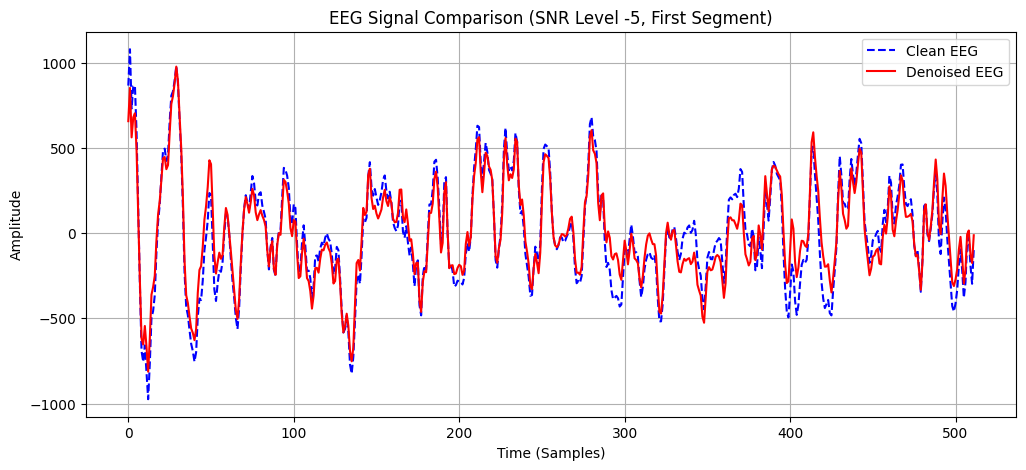

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure required variables are loaded
try:
    print(f"✅ SNR Labels Shape: {snr_labels_test.shape}, Clean EEG Shape: {clean_eeg.shape}, Denoised EEG Shape: {denoised_eeg.shape}")
except NameError:
    print("❌ Variables are not defined. Re-run the data preparation and evaluation cells.")

# ✅ Convert SNR labels to integers safely
try:
    snr_labels_test_int = np.array([int(str(snr).replace("SNR_", "")) for snr in snr_labels_test])
    print(f"✅ Converted SNR Labels: {snr_labels_test_int[:10]} ...")  # Show first 10 for debugging
except Exception as e:
    print(f"❌ Error converting SNR labels: {e}")

# Set SNR level to check
snr_level = -5 

# ✅ Extract indices of test samples for the selected SNR level
snr_indices = np.where(snr_labels_test_int == snr_level)[0]

# ✅ Handle missing SNR level
if len(snr_indices) == 0:
    print(f"❌ No test samples found for SNR Level {snr_level}.")
else:
    print(f"\n📊 Found {len(snr_indices)} test samples for SNR Level {snr_level}")
    print(f"✅ SNR Level {snr_level} indices in test set: {snr_indices.tolist()}")

    # ✅ Select the first segment
    first_segment_idx = snr_indices[0]

    # ✅ Extract EEG segments
    clean_segment = clean_eeg[first_segment_idx]
    denoised_segment = denoised_eeg[first_segment_idx]

    # ✅ Reconstruct Contaminated EEG by summing all frequency bands
    contaminated_bands = [test_data[band][1] for band in bands]
    contaminated_eeg = np.sum(contaminated_bands, axis=0)
    contaminated_segment = contaminated_eeg[first_segment_idx]

    # ✅ Plot EEG signals
    plt.figure(figsize=(12, 5))
    plt.plot(clean_segment, label="Clean EEG", linestyle="dashed", color="blue", linewidth=1.5)
    plt.plot(denoised_segment, label="Denoised EEG", linestyle="solid", color="red", linewidth=1.5)
    #plt.plot(contaminated_segment, label="Contaminated EEG", linestyle="dotted", color="green", linewidth=1.5)
    
    plt.title(f"EEG Signal Comparison (SNR Level {snr_level}, First Segment)")
    plt.xlabel("Time (Samples)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()


In [27]:
# ✅ Get denoised EEG plotting points
x_points = list(range(len(denoised_segment)))      # X-axis: time/sample index
y_points = denoised_segment.tolist()               # Y-axis: denoised EEG values

# ✅ Print the plotting points
print("Denoised EEG Plotting Points:")
for x, y in zip(x_points, y_points):
    print(f"({x}, {y})")

Denoised EEG Plotting Points:
(0, 657.1886596679688)
(1, 852.43798828125)
(2, 562.0908203125)
(3, 679.3780517578125)
(4, 703.5309448242188)
(5, 486.9898986816406)
(6, 104.67577362060547)
(7, -278.9789733886719)
(8, -618.5543823242188)
(9, -653.9256591796875)
(10, -544.8233642578125)
(11, -667.6282958984375)
(12, -813.12255859375)
(13, -618.8348999023438)
(14, -361.3650207519531)
(15, -316.0457458496094)
(16, -249.8921356201172)
(17, -43.37907409667969)
(18, 109.02386474609375)
(19, 189.03489685058594)
(20, 315.0327453613281)
(21, 439.279052734375)
(22, 446.8822021484375)
(23, 375.32318115234375)
(24, 399.513916015625)
(25, 588.2628173828125)
(26, 757.6398315429688)
(27, 805.0187377929688)
(28, 880.1046142578125)
(29, 977.3635864257812)
(30, 894.7244262695312)
(31, 686.7328491210938)
(32, 496.8918151855469)
(33, 207.9848175048828)
(34, -164.57183837890625)
(35, -364.3109130859375)
(36, -410.4025573730469)
(37, -489.46966552734375)
(38, -559.593505859375)
(39, -585.5653686523438)
(40, -6

In [29]:
# ✅ Get denoised EEG plotting points
x_points = list(range(len(clean_segment)))      # X-axis: time/sample index
y_points = clean_segment.tolist()               # Y-axis: denoised EEG values

# ✅ Print the plotting points
print("Clean EEG Plotting Points:")
for x, y in zip(x_points, y_points):
    print(f"({x}, {y})")

Clean EEG Plotting Points:
(0, 866.0310668945312)
(1, 1079.484130859375)
(2, 731.6409301757812)
(3, 862.6738891601562)
(4, 866.7140502929688)
(5, 588.8504028320312)
(6, 136.66143798828125)
(7, -298.35662841796875)
(8, -691.608642578125)
(9, -754.778564453125)
(10, -658.8089599609375)
(11, -812.54345703125)
(12, -974.6163940429688)
(13, -764.3228759765625)
(14, -497.63824462890625)
(15, -456.69189453125)
(16, -364.16766357421875)
(17, -113.02513885498047)
(18, 65.3680419921875)
(19, 168.07069396972656)
(20, 334.055419921875)
(21, 487.0714416503906)
(22, 495.9732360839844)
(23, 423.62994384765625)
(24, 460.7734375)
(25, 654.1538696289062)
(26, 806.8607788085938)
(27, 831.9862670898438)
(28, 895.39453125)
(29, 980.781494140625)
(30, 880.4319458007812)
(31, 661.5908203125)
(32, 461.5799255371094)
(33, 154.7933349609375)
(34, -231.58509826660156)
(35, -433.34747314453125)
(36, -481.13232421875)
(37, -568.77734375)
(38, -649.6075439453125)
(39, -692.3427124023438)
(40, -753.9926147460938)
(4

In [18]:
def normalize_signals(data):
    """Return normalized data, means, and stds per segment (row)."""
    mean = np.mean(data, axis=1, keepdims=True)
    std = np.std(data, axis=1, keepdims=True)
    normalized = (data - mean) / std
    return normalized, mean, std

def denormalize_signals(normalized, mean, std):
    """Reconstruct original signals from normalized form."""
    return (normalized * std) + mean


In [17]:
# ✅ Get denoised EEG plotting points
x_points = list(range(len(denoised_segment)))      # X-axis: time/sample index
y_points = denoised_segment.tolist()               # Y-axis: denoised EEG values

# ✅ Print the plotting points
print("Denoised EEG Plotting Points:")
for x, y in zip(x_points, y_points):
    print(f"({x}, {y})")

Denoised EEG Plotting Points:
(0, 0.41595181822776794)
(1, 0.8609888553619385)
(2, 1.162634253501892)
(3, 1.3677676916122437)
(4, 0.933000922203064)
(5, 0.5720016360282898)
(6, 0.670853853225708)
(7, 0.6370759606361389)
(8, 0.1839619129896164)
(9, 0.0035499692894518375)
(10, 0.2064511775970459)
(11, 0.2230602651834488)
(12, 0.1407758742570877)
(13, 0.2758827805519104)
(14, 0.5037899017333984)
(15, 0.6879937052726746)
(16, 0.7874892950057983)
(17, 0.6201406121253967)
(18, 0.4805481433868408)
(19, 0.8087640404701233)
(20, 1.2847554683685303)
(21, 1.392065167427063)
(22, 1.2854446172714233)
(23, 1.0511592626571655)
(24, 0.7004910707473755)
(25, 0.7552125453948975)
(26, 1.2588530778884888)
(27, 1.2892346382141113)
(28, 0.7398556470870972)
(29, 0.5196182727813721)
(30, 0.6921223998069763)
(31, 0.5298998355865479)
(32, 0.269804984331131)
(33, 0.4440503418445587)
(34, 0.6065389513969421)
(35, 0.27468371391296387)
(36, 0.04807799309492111)
(37, 0.35486701130867004)
(38, 0.5407588481903076)
(39

In [20]:
# ✅ Get denoised EEG plotting points
x_points = list(range(len(contaminated_segment)))      # X-axis: time/sample index
y_points = denoised_segment.tolist()               # Y-axis: denoised EEG values

# ✅ Print the plotting points
print("Contaminatedf EEG Plotting Points:")
for x, y in zip(x_points, y_points):
    print(f"({x}, {y})")

Contaminatedf EEG Plotting Points:
(0, 1.1689929962158203)
(1, 1.9662199020385742)
(2, 2.6759817600250244)
(3, 3.734178066253662)
(4, 2.183748483657837)
(5, 0.704386830329895)
(6, 1.7596099376678467)
(7, 2.8765628337860107)
(8, 1.7972841262817383)
(9, 1.09077787399292)
(10, 1.8402924537658691)
(11, 1.807940125465393)
(12, 0.9264942407608032)
(13, 0.7254466414451599)
(14, 1.3334693908691406)
(15, 2.1910154819488525)
(16, 2.5615148544311523)
(17, 1.849653720855713)
(18, 1.4280775785446167)
(19, 2.644353151321411)
(20, 4.099677562713623)
(21, 4.300961017608643)
(22, 3.8564112186431885)
(23, 2.764322280883789)
(24, 1.3831065893173218)
(25, 1.713373064994812)
(26, 3.351916790008545)
(27, 3.1821608543395996)
(28, 1.4570151567459106)
(29, 1.0878089666366577)
(30, 1.6937713623046875)
(31, 1.1402806043624878)
(32, 0.32812196016311646)
(33, 0.5848128795623779)
(34, 0.7577276229858398)
(35, 0.02378445863723755)
(36, -0.21873992681503296)
(37, 0.8165966272354126)
(38, 1.7307945489883423)
(39, 1.00